# Support Vector Machines and overfitting
In lessons, we've discussed the mechanism of "Support Vector Machines". Let's try this out in practice and explore the results. 

First, let's generate an interesting binary classification problem to try to solve. 

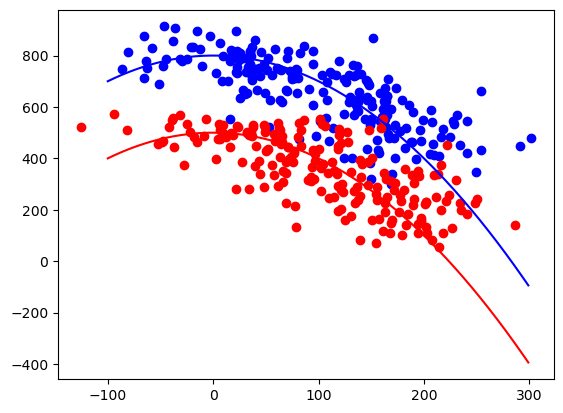

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
pop1 = pd.DataFrame({"x": np.random.normal(0,50,200), "y": np.random.normal(0, 50, 200)})
pop1['label'] = 1
pop2 = pd.DataFrame({"x": np.random.normal(0,50,200), "y": np.random.normal(0, 50, 200)})
pop2['label'] = -1

# generate a cloud around a quadratic function
quadratic_x = np.random.uniform(0, 200, 200)
quadratic_y = 500 - (quadratic_x/10)**2

# now replicate the cloud in two places, via a 300 unit y translation
pop1['x'] += quadratic_x
pop1['y'] += quadratic_y + 300
pop2['x'] += quadratic_x
pop2['y'] += quadratic_y

# plot the points of these
plt.plot(pop1['x'].values, pop1['y'].values, 'bo')
plt.plot(pop2['x'].values, pop2['y'].values, 'ro')

# plot the centerlines of the quadratic functions
plt.plot(np.arange(-100,300), 500 - (np.arange(-100,300)/10)**2, "r-")
plt.plot(np.arange(-100,300), 500 - (np.arange(-100,300)/10)**2 + 300, "b-")

df = pd.concat([pop1, pop2])
df = shuffle(df)

I constructed this so that we "know the answer." The data is distributed along two quadratic curves with noise, so that the dividing line between the curves is also roughly quadratic. 

I also wrote you a visualization routine that will allow you to visually check the results of modifying the SVC model. 

In [2]:
# and here's a useful visualization of the results of training, on every point in the plane. 
def make_meshgrid(x, y, h=1):
    x_min = x.min() - 1
    x_max = x.max() + 1
    y_min = y.min() - 1
    y_max = y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, model, xx, yy, **params):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)

def visualize(model, df):
    X = df.loc[:, ['x', 'y']].values
    y = df.loc[:, 'label'].values
    fig, ax = plt.subplots()
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1, 2)
    plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    plt.show()

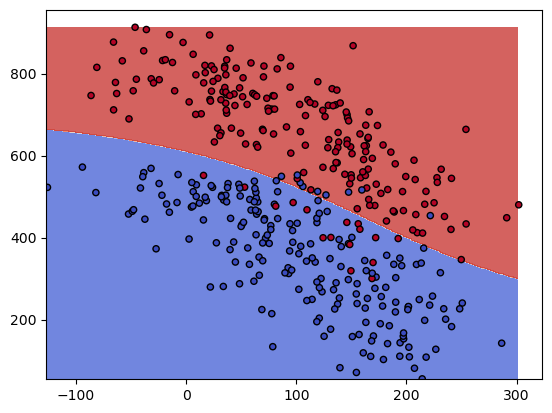

In [3]:
# and let's test this with default parameters
from sklearn import svm
model = svm.SVC().fit(df.loc[:,['x', 'y']].values, df.loc[:, 'label'])
visualize(model, df)

Note that we are testing with a Radial Basis Function (RBF) even though we know (in secret) that the actual relationship is polynomial. This is true throughout this exercise. In the real world, we won't know things like this in advance. 

Question 1: Read https://scikit-learn.org/stable/modules/cross_validation.html and run a cross-validation on the model above using `train_test_split` to separate the data into training and testing vectors. Hints: the data is still in a DataFrame and you'll have to grab it from there. You'll have to retrain the model on new training data. Put the final model into the variable `model` and the final score into the variable `score`.

In [4]:
from sklearn.model_selection import train_test_split
# set score to the mean accuracy of the predictions
# BEGIN SOLUTION
# Prepare the data
X = df.loc[:, ['x', 'y']].values
y = df.loc[:, 'label'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Train the model
model.fit(X_train, y_train)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
score = np.mean(clf.score(X_test, y_test))

# END SOLUTION
score

0.9375

In [5]:
assert isinstance(model, svm._classes.SVC)

In [6]:
assert model.kernel == 'rbf'

Question 2: Still referring to https://scikit-learn.org/stable/modules/cross_validation.html, use the helper function `cross_val_score` to do repeated accuracy tests. Do 5 tests and place the results in a list `scores`

In [7]:
from sklearn.model_selection import cross_val_score
# set score to the mean accuracy of the predictions
# BEGIN SOLUTION

clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
score = np.mean(scores)

# END SOLUTION
score

0.925

Question 3: Read https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py and then manipulate `C` and `gamma` for the `rbf` kernel so that the result is dramatically overfitted.  Leave your overfitted model in the variable `model`. 

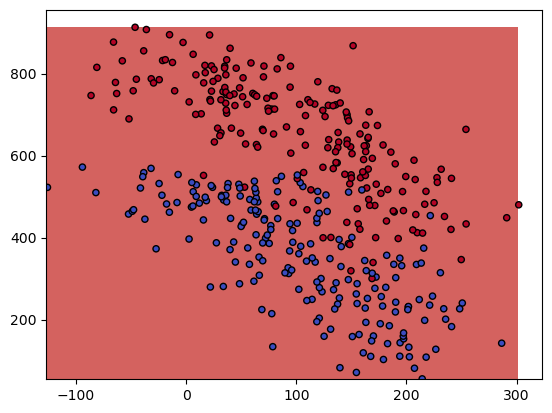

In [8]:
from sklearn import svm
# create a variable `model` to contain the classifier, including the values of C and gamma parameters. 
# BEGIN SOLUTION

# Create an overfitted model by setting very high values of C and gamma
model = svm.SVC(kernel='rbf', C=1e5, gamma=1e3)

# END SOLUTION
model.fit(df.loc[:, ['x', 'y']].values, df.loc[:, 'label'].values)
visualize(model, df)

In [9]:
assert isinstance(model, svm._classes.SVC)

In [10]:
assert model.kernel == 'rbf'

Question 4: Repeat the cross-validation scoring from Question 2. What is the accuracy of this approach?  

In [11]:
# leave the result in the variable scores 
# BEGIN SOLUTION

clf = svm.SVC(kernel='rbf', C=1e5, gamma=1e3)
scores = cross_val_score(clf, X, y, cv=5)
# END SOLUTION
scores

array([0.5, 0.5, 0.5, 0.5, 0.5])

Question 5: It's claimed in the reading that one can create an overfitted example that scores well and perhaps even better than a reasonable fit. Try to reproduce that result with this data by manipulating the model. Score the model and visualize your result. You might want to try other kernels, e.g., 'poly' and see how they react to this data. How well can you do at scoring highly with an overfitted model? 

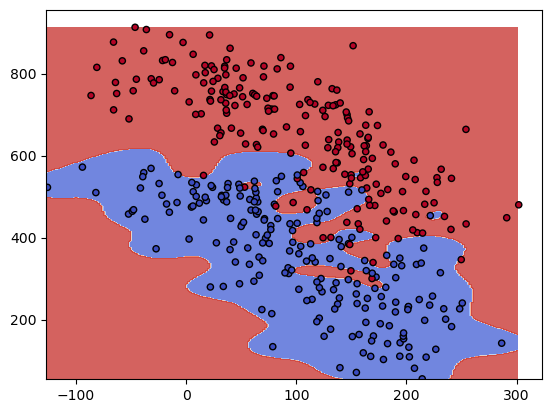

array([0.9   , 0.8875, 0.8875, 0.825 , 0.825 ])

In [16]:
# BEGIN SOLUTION

# Try to manipulate C and gamma for the rbf kernel for forcing overfitting
model = svm.SVC(kernel='rbf', C=1e6, gamma=0.0005)
model.fit(df.loc[:, ['x', 'y']].values, df.loc[:, 'label'].values)

scores1 = cross_val_score(model, X, y, cv=5)

# Try to manipulate the parameters for a polynomial kernal for overfitting w/ high scores
# model2 = svm.SVC(kernel='poly', degree=5, C=1, gamma='auto')  # Higher degree, high C
# model2.fit(df.loc[:, ['x', 'y']].values, df.loc[:, 'label'].values)

# scores2 = cross_val_score(model2, X, y, cv=5)


# END SOLUTION 
visualize(model, df)
# visualize(model2, df)
scores1
# scores2